# Recommendation of books
Author: Luke Huisman<br>
Student number: 684651<br>
Date: 22-03-2025

Before working within this notebook, please ensure that you have activated your virtual environment (venv). Activating the venv ensures that you are using the correct versions of the packages required for this notebook.

### Activating the venv

To activate the venv, use the following commands:

- On Windows:
    ```sh
    .\venv\Scripts\activate
    ```

- On macOS/Linux:
    ```sh
    source venv/bin/activate
    ```

### No venv yet?

If you have not yet created a virtual environment, you can do so by running the following command in your terminal:

```sh
python -m venv venv
```
After creating the venv, you will need to install one package manually. This package is `ipykernel`, which is required for Jupyter Notebook to work properly. You can install it by running the following command:

```sh
pip install ipykernel
```
Once you have activated the venv and installed the required packages, you can start working within this notebook. If you encounter any issues or have questions, please feel free to reach out for assistance.

### Importing the required libraries
For this notebook to work you must have installed the following packages:
* pandas
* matplotlib

For your convenience, the notebook will check if these packages are installed. If not, it will install them for you. **MAKE SURE TO ACTIVATE YOUR VENV FIRST!**

In [209]:
import subprocess
import sys

def install(package):
    print(f"Installing {package}, please wait...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import pandas as pd
except ImportError:
    install('pandas')
    import pandas as pd
try:
    import matplotlib.pyplot as plt
except ImportError:
    install('matplotlib')
    import matplotlib.pyplot as plt

# 1. The Item-Based Recommender

We are going to build an item-based recommender for books. In this recommender we could for example recommend books that are similar to a book that a user has already read.

To begin you'll need to download the dataset from [kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset). Move the dataset to the [/data](/data) folder and extract the files in there. The dataset contains a few files, but we won't be using all of them.

We'll only be using the books.csv and ratings.csv files. The books.csv file contains information about the books, and the ratings.csv file contains information about the ratings that users have given to the books.

In [210]:
try:
    books_df: pd.DataFrame = pd.read_csv('data/books.csv')
    ratings_df: pd.DataFrame = pd.read_csv('data/ratings.csv')
except FileNotFoundError:
    print("Please download the data file(s) from kaggle repository and or rename them accordingly.")
    sys.exit(1)

/tmp/ipykernel_21442/4217012320.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df: pd.DataFrame = pd.read_csv('data/books.csv')


## Let's take a quick look at the data head

In [211]:
print(books_df.head())
print(ratings_df.head())

         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/

The data from the dataset is quite extensive, but it also has a lot of unneccesary columns. We can for example from the books dataset drop all columns except for the ISBN and the Book-Title as we won't be needing the other columns for the recommender system.

We furthermore will clean the data a little bit before hand by removing any ratings that are 0, as these are not useful for our recommender system. We will also remove any entries where the user has given multiple ratings for the same book, as this is likely an error in the dataset.

In [212]:
# Only select from the books_df the columns ISBN and Book-Title
books_df = books_df[['ISBN', 'Book-Title']]

# Remove all rows from the ratings_df where the Book-Rating is 0
ratings_df = ratings_df[ratings_df['Book-Rating'] != 0]

# Remove all duplicate ratings where the same user rated the same book multiple times
ratings_df = ratings_df.drop_duplicates(subset=['ISBN', 'User-ID'])

# Merge the two dataframes on the ISBN column
df = books_df.merge(ratings_df, on='ISBN')

Now that the data has been picked, we can take another look at the data.

In [213]:
print(df.head())

         ISBN    Book-Title  User-ID  Book-Rating
0  0002005018  Clara Callan        8            5
1  0002005018  Clara Callan    11676            8
2  0002005018  Clara Callan    67544            8
3  0002005018  Clara Callan   116866            9
4  0002005018  Clara Callan   123629            9


This already looks a lot better. We can see that the data is now much more readable and that we have removed a lot of the unnecessary columns.

We also need to take the counts into consideration so lets keep those into their own dataframe, together with the average score:

In [214]:
# Create a new dataframe where each row is a book and the columns are the average rating and the number of ratings
average_ratings = df.groupby('ISBN')['Book-Rating'].agg(['mean', 'count'])
# Reset the index so that ISBN is a column
average_ratings.reset_index(inplace=True)
# Rename the columns to Average-Rating and Number-of-Ratings
average_ratings.columns = ['ISBN', 'Average-Rating', 'Number-of-Ratings']

To decide on a cut-off point as minimum number of scores to be eligable we can plot the number of scores in a histogram:

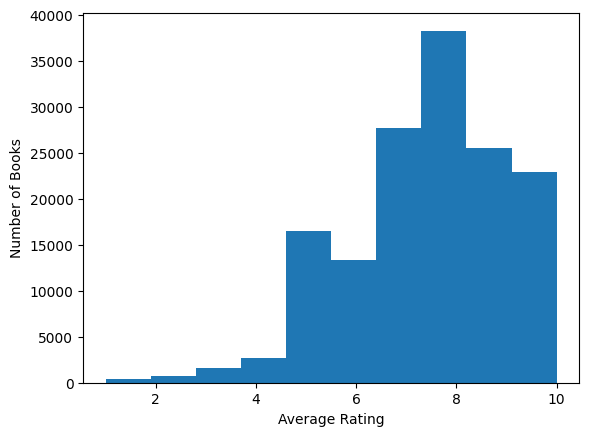

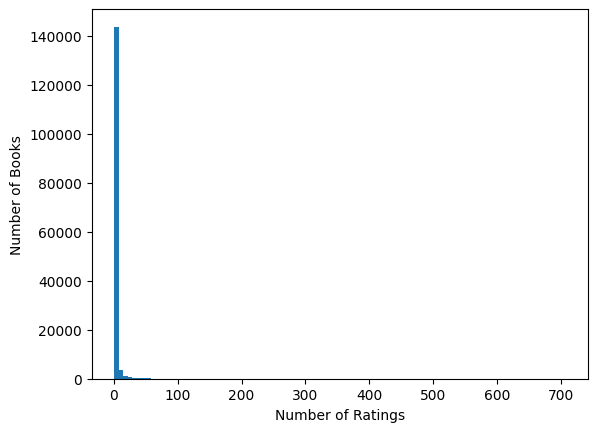

In [215]:
plt.hist(average_ratings['Average-Rating'], bins=10)
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')
plt.show()

plt.hist(average_ratings['Number-of-Ratings'], bins=100)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Books')
plt.show()

From the histogram we can see that there are a lot of book with a lot amount of ratings, while most books have very few ratings. We can see that the majority of books have less than 100 ratings. We can use this information to decide on a cut-off point. We can for example decide that a book needs at least 25 ratings to be eligible for the recommender system.

Let's drop all rows where the number of ratings is less than 25 and take another peek at the data:

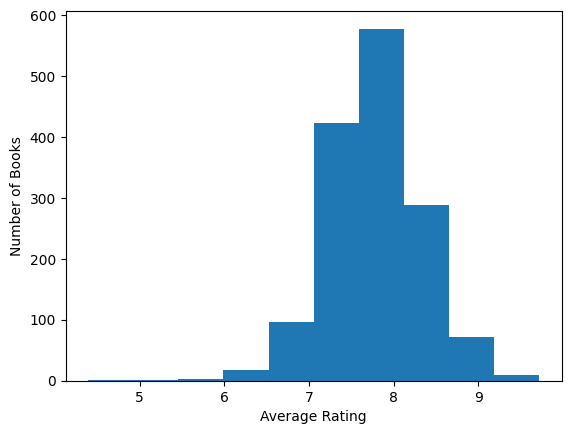

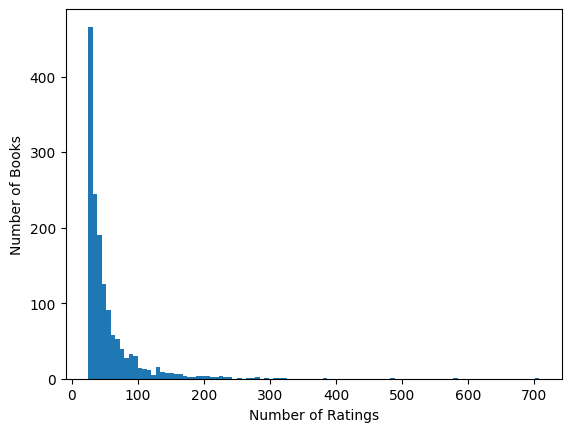

In [216]:
# Apply minimum rating count threshold
min_ratings = 25
average_ratings = average_ratings[average_ratings["Number-of-Ratings"] >= min_ratings]

plt.hist(average_ratings["Average-Rating"], bins=10)
plt.xlabel("Average Rating")
plt.ylabel("Number of Books")
plt.show()

plt.hist(average_ratings["Number-of-Ratings"], bins=100)
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Books")
plt.show()

We can see that many of the very low ratings have been removed from the dataset. We can loosly conclude that the ratings and books that have been removed are not very popular or were outliers in the dataset. Making the dataset more reliable for our recommender system.

Finally we can create the code to perform a recommendation. First we can select one particular book.

In [217]:
# Select a random book for recommendation
book = average_ratings.sample(random_state=42).merge(books_df, on="ISBN")
selected_book_isbn = book["ISBN"].values[0]
print(book)

         ISBN  Average-Rating  Number-of-Ratings  \
0  0452264464        7.772152                 79   

                             Book-Title  
0  Beloved (Plume Contemporary Fiction)  


We need one row per user, and his/her scores for each book. We can do this by creating a pivot table. 

In [218]:
# Filter the main dataset to include only books meeting the threshold
df = df[df['ISBN'].isin(average_ratings['ISBN'])]

# Create a pivot table where the rows are the User-ID, the columns are the ISBN, and the values are the Book-Rating
pivot_table = df.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')
print(pivot_table)

ISBN     000649840X  0007110928  0020442203  002542730X  0028604199  \
User-ID                                                               
9               NaN         NaN         NaN         NaN         NaN   
16              NaN         NaN         NaN         NaN         NaN   
26              NaN         NaN         NaN         NaN         NaN   
39              NaN         NaN         NaN         NaN         NaN   
42              NaN         NaN         NaN         NaN         NaN   
...             ...         ...         ...         ...         ...   
278843          NaN         NaN         NaN         NaN         NaN   
278844          NaN         NaN         NaN         NaN         NaN   
278846          NaN         NaN         NaN         NaN         NaN   
278851          NaN         NaN         NaN         NaN         NaN   
278854          NaN         NaN         NaN         NaN         NaN   

ISBN     006000438X  0060008032  0060008776  0060090367  0060096195  ...  \


And then to find the recommendation based on the correlations.

In [219]:
# Compute correlation with additional filtering
def compute_correlation(isbn, min_common_ratings=5):
    if isbn not in pivot_table:
        return None

    book_ratings = pivot_table[isbn]
    common_ratings_count = (pivot_table.notna().astype(int).T.dot(book_ratings.notna().astype(int)))

    valid_books = common_ratings_count[common_ratings_count >= min_common_ratings].index
    correlation = pivot_table[valid_books].corrwith(book_ratings)

    correlation_df = pd.DataFrame(correlation, columns=["Correlation"]).dropna()
    correlation_df = correlation_df.merge(average_ratings, on="ISBN")

    # Exclude the ISBN being searched for from the recommendations
    correlation_df = correlation_df[correlation_df["ISBN"] != isbn]

    return correlation_df.sort_values(by="Correlation", ascending=False)

# Get the top 10 books with the highest correlation
top_10_books = compute_correlation(selected_book_isbn, min_common_ratings=5).head(10)
print(top_10_books)

          ISBN  Correlation  Average-Rating  Number-of-Ratings
8   0440498058     0.946100        8.876543                 81
0   0156027321     0.813733        8.030973                226
11  059035342X     0.707475        8.939297                313
3   0375727345     0.454794        7.327511                229
4   0380002930     0.431310        8.620000                100
14  1573225789     0.414265        8.250000                 92
2   0316899984     0.403604        6.830769                 65
9   0446672211     0.332605        8.142373                295
12  067976402X     0.323390        7.808594                256
5   0385484518     0.000000        8.615000                200


The highest correlation book (0.946) is almost perfectly correlated with "Beloved." This suggests that users who liked "Beloved" also highly rated this book. <br>

Harry Potter (ISBN: 059035342X) appears in the recommendations. This could be due to its wide readership rather than direct thematic similarity.<br>

Lower-correlation books still have decent ratings, but they share fewer overlapping reviewers with the selected book.<br>

It might be nice to have one simple function that could do all the work for us. It should have as input parameters a dataframe, specific field, and minimum number of ratings, and then returns the recommendation.

Note that you should first select the fields that meet the minimum number of ratings, and then perform the correlation matrix, etc.

In [220]:
def generate_recommendations(df, isbn, min_ratings=25):
    df = df[df['ISBN'].isin(average_ratings['ISBN'])]

    pivot_table = df.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')

    # Compute correlation with additional filtering
    return compute_correlation(isbn, min_ratings)

Lets test the function:<br>
Take for example the book "The Fellowship of the Ring" (ISBN: `0618002227`) and see what the recommender system comes up with.<br>
Take for example the book "The Da Vinci Code" (ISBN: `0385504209`) and see what the recommender system comes up with.<br>
Take for example the book "Jurassic Park" (ISBN: `0345370775`) and see what the recommender system comes up with.<br>

In [221]:
# The function should return a dataframe with the top 10 recommendations based on the correlation with the selected book.
while True:
    #input_isbn = input("Enter the ISBN of the book you want recommendations for: ")
    input_isbn = "0345370775"
    if input_isbn in average_ratings['ISBN'].values:
        break
    else:
        print("Invalid ISBN. Please try again.")
        print("Available ISBNs:")
        print(average_ratings.sample(10, random_state=None).merge(books_df, on="ISBN")[['ISBN', 'Book-Title']])

# Generate recommendations
reccommendations = generate_recommendations(df, input_isbn, min_ratings=25)
reccommendations = reccommendations.merge(books_df, on="ISBN")[["ISBN", "Book-Title", "Correlation", "Average-Rating", "Number-of-Ratings"]]
print(reccommendations.head(10))

Empty DataFrame
Columns: [ISBN, Book-Title, Correlation, Average-Rating, Number-of-Ratings]
Index: []


<font size="5"><center>-----Chapters 1 is required to be fully completed to get a 60, the next few chapters will give a +10 for each chapter.<br> 
    However no template is available for these chapters. You will have to create it yourself.
    ----</center></font>

# 2. Negative correlations

The recommenders so far used, are looking at what if I give a high rating for this, what do you then recommend me. But how about if I give a low rating for something, what would you then recommend me?

Explain how and why your solution works, and how to interpret the results.

# 3. Content Based

Add a chapter showing how a basic content based recommender might work. A starting point for this might be https://www.datacamp.com/community/tutorials/recommender-systems-python (at about 1/3 of the page it starts explaining this in the section called ‘Content based’.

# 4. User Based

Add a chapter showing how a basic user based recommender might work. A starting point for this might be https://realpython.com/build-recommendation-engine-collaborative-filtering/

# 5. Combination

Combine two or more recommendation techniques to get an even better recommendation